## Paso 0 - Importar librerias y establecer conexion

In [520]:
import pandas as pd
import pymongo
import matplotlib
import re
from pandas import json_normalize
import folium

In [521]:
#conexion a la bd de mongo
client = pymongo.MongoClient("localhost", 27017)

In [522]:
#establecer base de datos que se utilizara
db = client.company
#db.name

In [523]:
#db.companies

In [524]:
#explotar los nombres de los campos en la collecion
list(db.companies.find().limit(1))[0].keys()

dict_keys(['_id', 'name', 'permalink', 'crunchbase_url', 'homepage_url', 'blog_url', 'blog_feed_url', 'twitter_username', 'category_code', 'number_of_employees', 'founded_year', 'founded_month', 'founded_day', 'deadpooled_year', 'tag_list', 'alias_list', 'email_address', 'phone_number', 'description', 'created_at', 'updated_at', 'overview', 'image', 'products', 'relationships', 'competitions', 'providerships', 'total_money_raised', 'funding_rounds', 'investments', 'acquisition', 'acquisitions', 'offices', 'milestones', 'video_embeds', 'screenshots', 'external_links', 'partners'])

## Paso 1 - Detectar el tipo de empresa

#### Partamos de la premisa que deseamos iniciar una start-up pero no sabemos a que se dedicara ni en que zona iniciar el negocio

#### Para fijar una categoria a la start-up vamos a  guiarnos con las empresas parecidas a una start-up en nuestra  data ( que sea negocios pequeños)

In [525]:
#se realiza un query en la bd para traernos los registros donde los empleados esten entre 5 a 75 como maximo
query= db.companies.find({'offices':{'$exists':True},'ipo':{'$exists':True},
                         '$and':[{'number_of_employees':{'$gte':5}},
                                 {'number_of_employees':{'$lte':75}}]},
                       {'name':1,'category_code':1 ,'number_of_employees':1,'total_money_raised':1,'founded_year':1,'offices':1 ,'ipo':1})

In [526]:
#guardamos los valores normalizados
data = pd.json_normalize(query)

In [527]:
# creamos un dataframe
df = pd.DataFrame(data)

In [528]:
#evaluamos la informacion general de nuestros datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4875 entries, 0 to 4874
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   _id                          4875 non-null   object 
 1   name                         4875 non-null   object 
 2   category_code                4851 non-null   object 
 3   number_of_employees          4875 non-null   int64  
 4   founded_year                 4626 non-null   float64
 5   total_money_raised           4875 non-null   object 
 6   offices                      4875 non-null   object 
 7   ipo                          0 non-null      float64
 8   ipo.valuation_amount         3 non-null      float64
 9   ipo.valuation_currency_code  8 non-null      object 
 10  ipo.pub_year                 6 non-null      float64
 11  ipo.pub_month                6 non-null      float64
 12  ipo.pub_day                  6 non-null      float64
 13  ipo.stock_symbol  

##### Graficamos las 5 categorias con mayor aparacicion en el mercado

<AxesSubplot:ylabel='category_code'>

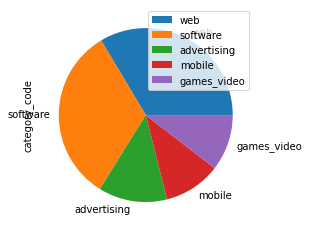

In [529]:
df['category_code'].value_counts().head(5).plot.pie(legend=True)

Se ven que hay dos categorias tiene la mayor presencia en las pequeñas empresas, para discriminar entre las categorias verificaremos cuando dinero generan

In [531]:
#limpiamo los valores de 'total_money_raised' y lo separamos en dos columnas: 
#'total_money_raised_int' para obtener los valores numericos y hacer mediciones
#'current' donde separamos las monedas utilizadas en la medicion
df['total_money_raised_int'] = df['total_money_raised'].str.replace(r'\$|€|£|C|r|¥','')
df['total_money_raised_int'] = df['total_money_raised_int'].str.replace(r'\.([0-9])M', r'\1 00000')
df['total_money_raised_int'] = df['total_money_raised_int'].str.replace(r'\.([0-9])B', r'\1 00000000')
df['total_money_raised_int'] = df['total_money_raised_int'].str.replace(r'\.([0-9][0-9])M', r'\1 00000')
df['total_money_raised_int'] = df['total_money_raised_int'].str.replace(r'\.([0-9][0-9])B', r'\1 0000000')
df['total_money_raised_int'] = df['total_money_raised_int'].str.replace(r'\.([0-9])k', r'\1 00')
df['total_money_raised_int'] = df['total_money_raised_int'].str.replace(r'B', r'000000000')
df['total_money_raised_int'] = df['total_money_raised_int'].str.replace(r'M', r'000000')
df['total_money_raised_int'] = df['total_money_raised_int'].str.replace(r'k', r'000')
df['total_money_raised_int'] = df['total_money_raised_int'].str.replace(r' ', r'')
#df['total_money_raised_int']

In [532]:
#tranformamo el tipo de columna a entero
df['total_money_raised_int'] = df['total_money_raised_int'].astype('int64')
# reducimos la cantidad de ceros, trabajaremos como K como menor unidad
df['total_money_raised_int']= df['total_money_raised_int']/100000

##### Graficamos un boxplot para tener una nocion de los valores outline

<AxesSubplot:>

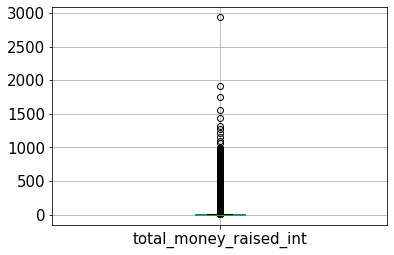

In [533]:
df.boxplot(column=['total_money_raised_int'], fontsize=15)

<AxesSubplot:>

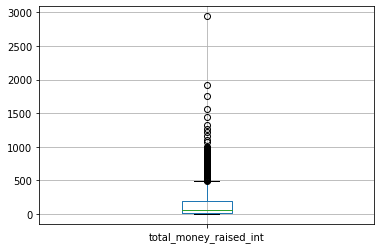

In [534]:
#Eliminamos los valores de empresas que generan 0$
df = df[df.total_money_raised_int != 0 ]
df.boxplot(column=['total_money_raised_int'])

<AxesSubplot:>

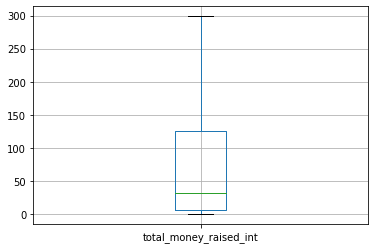

In [535]:
# limitamos el rango de los valores outline mas altos
df = df[df.total_money_raised_int < 300]
df.boxplot(column=['total_money_raised_int'])

Ahora poseemos un dataframe mas equilibrado con respecto a sus valores que podemos utilizar para algunas metricas

#### Graficamos las monedas mas utilizadas para verificar cual usaremos como metrica

<AxesSubplot:ylabel='current'>

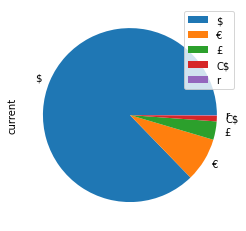

In [536]:
df['current'] = df['total_money_raised'].str.replace(r'[0-9]|\.|M|k',r'')
df['current'].value_counts().plot.pie(legend=True)

El dolar es la moneda que mayor presencia tiene en los ingresos de empresas 
asi que basaremos nuestro analisis en las ganancias usando $

In [537]:
#dejar solo los valores en $
df = df[df.current == '$']

#### Graficamos el top de ingresos en todas las categorias

<AxesSubplot:ylabel='category_code'>

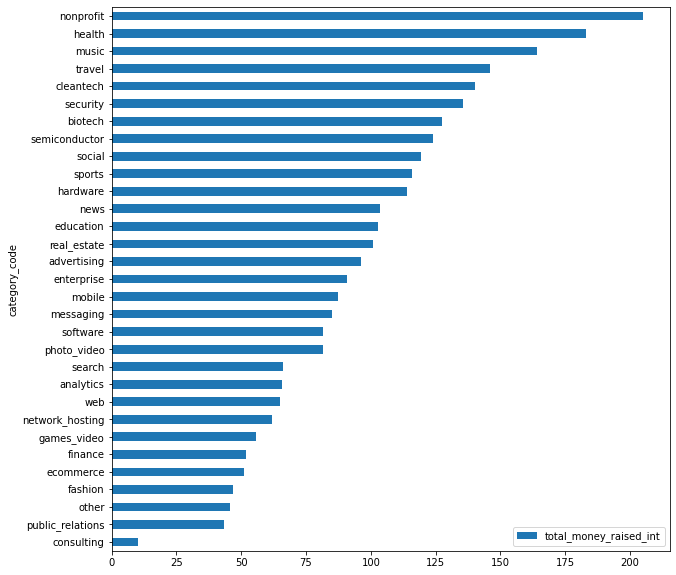

In [538]:
ds1 = df.groupby('category_code')['total_money_raised_int'].mean().sort_values()
ds1.plot.barh(legend=True,figsize=(10,10), stacked=True)


Aunque tenemos la monetizacion de todas los negocios por categorias, solo nos interesa saber las categorias de 'web' y 'software', ya que son las que tiene una mayor tendencia.

#### Escogemos la categoria de 'software' para nuestra empresa 
#### debido a que tener las mayores ganancias dentro de las categorias con mayor tendencia
#### Ahora revisaremos cual es la localizacion donde se concentran este tipo de negocios

## PASO 2 -  Localizacion de la empresa

In [539]:
#realizamos un query para traernos la informacion filtrando por la categoria que escogimos
#pero esta vez solo nos interesan la key de offices y sus valores internos
query= db.companies.find({'offices':{'$exists':True},
                         '$and':[{'number_of_employees':{'$gte':5}},
                                 {'number_of_employees':{'$lte':75}},
                                 {'category_code':'software'}
                                ]},
                       {'offices':1,'_id':0 })

In [540]:
#guardamos los valores en un df temporal para aplanarlos luego
dftemp= pd.DataFrame(query)
dftemp

,offices
0,"[{'description': '', 'address1': '700 Airport ..."
1,"[{'description': 'GoingOn Networks, Inc.', 'ad..."
2,"[{'description': '', 'address1': 'PO Box 15265..."
3,"[{'description': None, 'address1': '10 Cedar G..."
4,"[{'description': 'Headquarters', 'address1': '..."
...,...
958,"[{'description': 'Corporate Headquarters', 'ad..."
959,"[{'description': 'Headquarters', 'address1': '..."
960,"[{'description': '', 'address1': '143 Varick S..."
961,"[{'description': '', 'address1': '143 Varick S..."


In [541]:
#normalizamos los valores y los guardamos en un nuevo dataframe
list_1 = []
list_1 = [ j for i in dftemp['offices'].values.tolist() for j in i]
df3= pd.DataFrame(list_1)
df3

,description,address1,address2,zip_code,city,state_code,country_code,latitude,longitude
0,,700 Airport Blvd,,94010,Burlingame,CA,USA,NaN,NaN
1,"GoingOn Networks, Inc.",450 Sansome Street,12th Floor,94111,San Francisco,CA,USA,37.782263,-122.392142
2,,PO Box 15265,,85060,Phoenix,AZ,USA,33.429864,-111.944967
3,None,10 Cedar Grove,Castle Hill,2154,Sydney,None,AUS,-33.722577,150.981801
4,Headquarters,320 Blackwell Street,Suite 200,27701,Durham,NC,USA,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1090,Headquarters,Syvendehusvej 51A,,2730,Herlev,None,DNK,55.752525,12.393304
1091,,143 Varick Street,,10013,New York,NY,USA,40.726160,-74.006023
1092,,5200 Summerlin Commons Blvd.,Suite 500,33907,Fort Myers,FL,USA,26.579494,-81.879319
1093,,143 Varick Street,,10013,New York,NY,USA,40.726160,-74.006023


#### Graficamos el top de paises con mayor presencia de negocios dedicados a 'software'

<AxesSubplot:ylabel='country_code'>

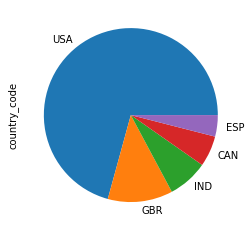

In [542]:
country = df3['country_code'].value_counts().head()
country.plot.pie()

Se puede visualizar que USA tiene el mayor numero de negocios, asi que la usaremos como referencia

#### Graficamos el top de Ciudades de USA mayor presencia de negocios dedicados a 'software'

<AxesSubplot:xlabel='Ciudades'>

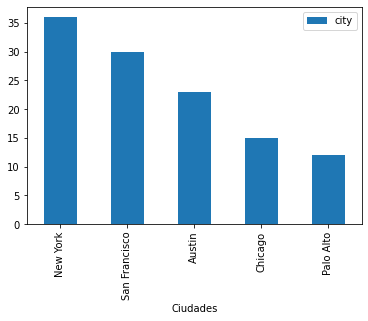

In [544]:
#filtramos por USA
df3 = df3[df3.country_code == 'USA' ]
# obtenemos el top de ciudades donde se encuentran la mayor cantidad de empresas
Cantidad_oficinas = pd.DataFrame(df3['city'].value_counts().rename_axis('Ciudades'))
Cantidad_oficinas.head().plot.bar( legend=True)

In [545]:
#Limitamos nuestro dataframe a solo los valores de latitude y longitud
df3 = df3[['city','latitude','longitude']]
df3 = df3.dropna()

In [546]:
#limitamos los valores 
df3 = df3[df3.city == 'New York' ]
df3 = df3.reset_index(drop=True)

In [547]:
#cantidad de oficinas
#len(df3)

31

#### Mapear la ubicacion de la Ciudad

In [549]:
mapa = folium.Map(location = [df3['latitude'][0],df3['longitude'][0]], zoom_start = 12)
mapa

#### Mapear en Nueva York las distintas empresas de 'software'

In [517]:
for i in range(len(df3)):
    folium.Marker([df3['latitude'][i],df3['longitude'][i]], icon=folium.Icon(color='blue'),popup = '<b>Officina de software</b>', tooltip = 'oficina').add_to(mapa)
    
mapa

#### Ubicar un radio de busqueda para abrir el negocio
#### - Basado en el punto medio entre todas las empresas ubicadas en New York

In [519]:
folium.CircleMarker([df3['latitude'].median(),df3['longitude'].median()], radius = 50, icon = folium.Icon()).add_to(mapa)
mapa